In [15]:
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)


Found and verified text8.zip


In [17]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


In [18]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3084, 12, 6, 195, 2, 3136, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [19]:

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

3084 originated -> 12 as
3084 originated -> 5237 anarchism
12 as -> 3084 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


In [28]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.initialize_all_variables()

# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

Initialized
Average loss at step  0 :  277.01940918
Nearest to had: pheasants, introduce, serum, lanzarote, manco, infraorder, priscus, maxillofacial,
Nearest to war: informally, sprays, masoretic, filenames, quarrelled, aleksander, gs, bachchan,
Nearest to years: taxable, martins, generalised, fans, mudd, bregovi, protege, summarized,
Nearest to nine: ostwald, mondale, englishmen, mindful, veneto, smaller, personification, minister,
Nearest to most: murals, consumerism, miyazaki, corcovado, rationale, mull, waffen, livelihood,
Nearest to i: dillon, incurable, zbigniew, preset, formulaic, khanates, meets, maxillofacial,
Nearest to that: nlds, conjugate, nazionale, orientational, isn, kadyrov, thaddeus, wolfhounds,
Nearest to so: coda, clever, clarifying, commandants, usury, industrious, anabaptism, scraped,
Nearest to history: keyboard, pitman, ng, receptacle, nhra, glans, niagara, learned,
Nearest to first: cic, pessimistic, anatole, philosophies, explainable, ventured, workaround, co

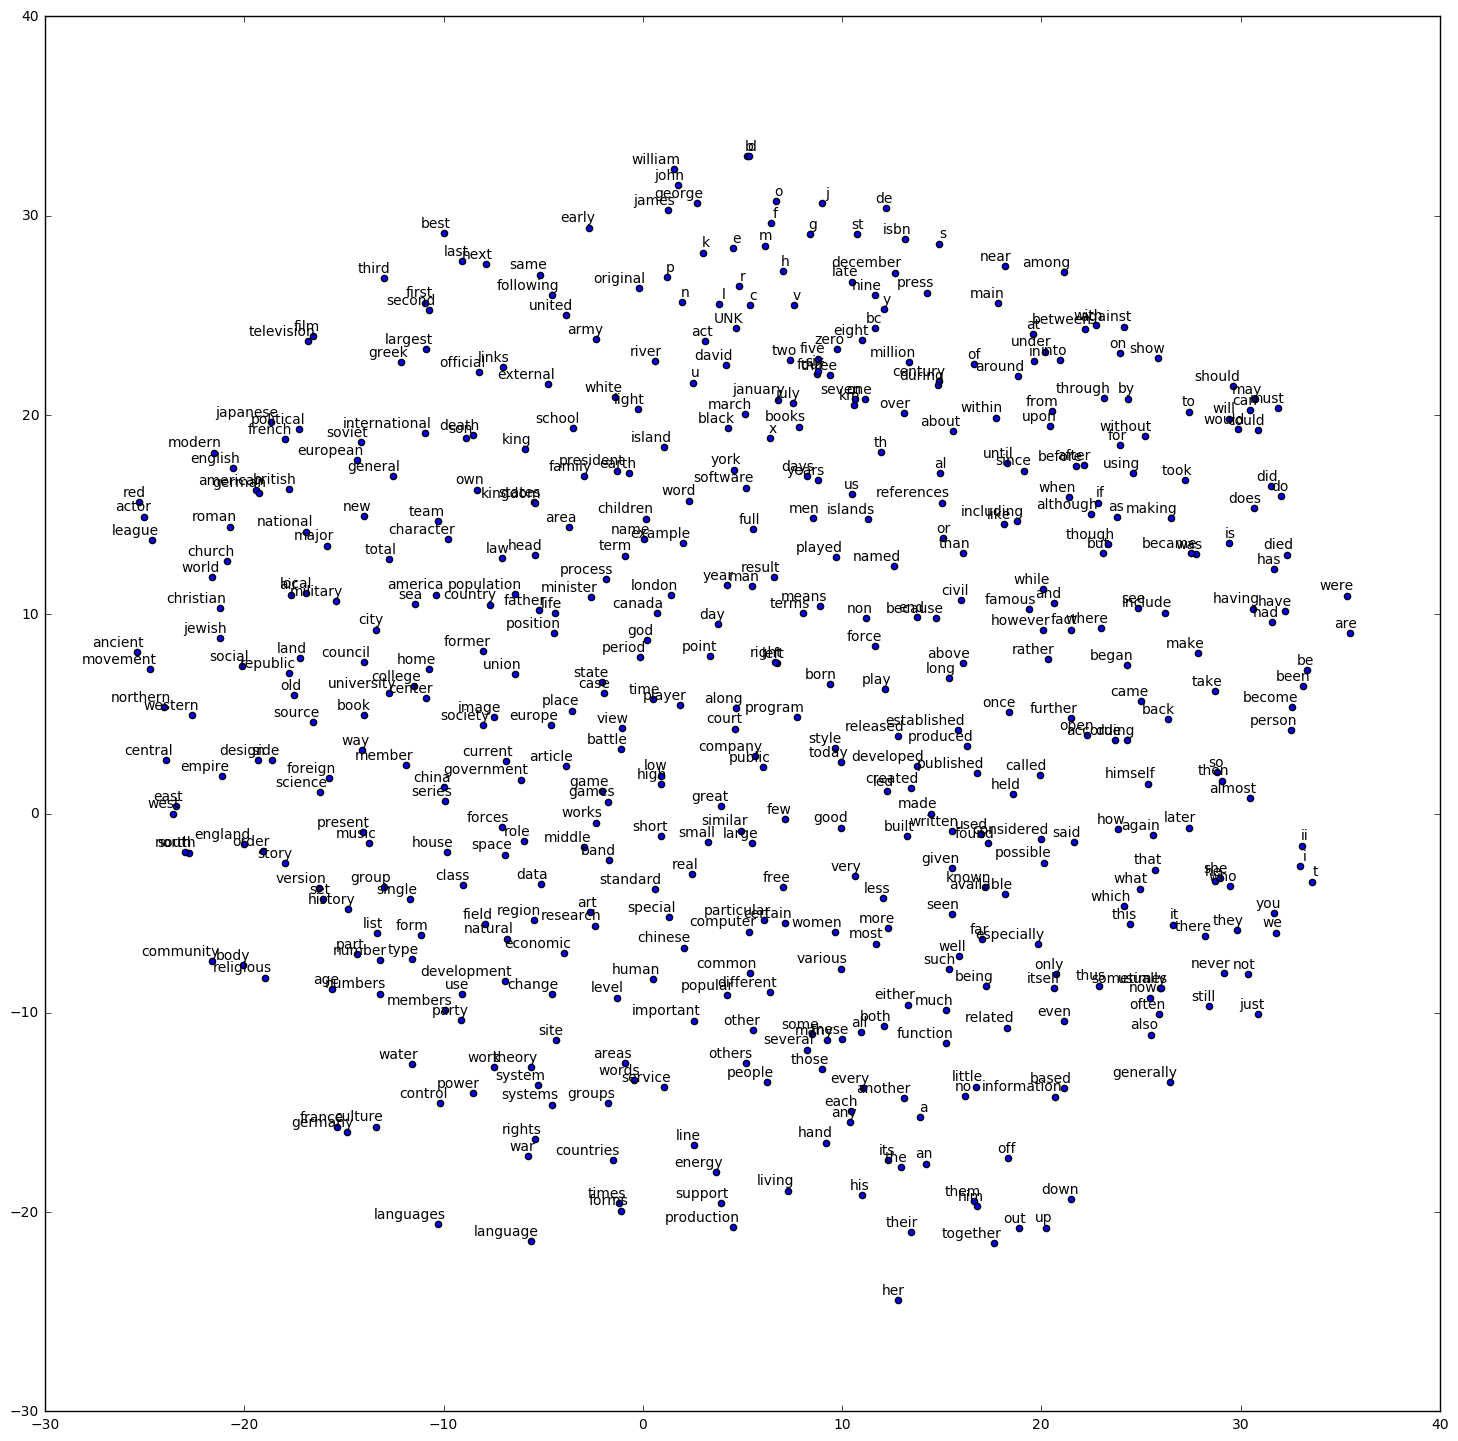

In [31]:
try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [30]:
% matplotlib inline

## The Plan

### Step 1
Train some actual word2vec sets. Understand how to use it. Then use CNNs for Language Understanding Stuff.
Use Gutenberg Library. Don't even think about changing the functions yet. Just use the for now.

### Step 2
Work through some analogical reasoning stuff. Practice optimizing, but ONLY as a means of understanding how to work with stuff. Try to understand how you would do author recognition with CNNs.

### Step 3
Read more papers. Understand more about what you've actually been doing. Write up some stuff on the link between CNNs and what you're doing. 

### Step 4
Implement a version of word2vec that allows for an increase in the vocabulary. 

### Step 5a
Implement a version of word2vec that adds bigram transitions. The main focus here is clustering transitions and integration of unknown vocab. When we see a known transition, we add it into the context.

### Step 5b
Add a graph on top of the network and begin looking at methods to choose link likelihood

### Step 6
Combine network and word2vec with bigram transitions. Recognize words as transitions. Especially that. Actually. You might even just try recognizing 3 word transitions like $a \xrightarrow{b} c$, that's probably the most concrete place to start. Also play around with a high dropout rate. So train batch. Drop / cluster a bunch then continue.

### Step 7
Try implimenting adding in trigrams inbetween bigrams. Basically, train two contexts once you've trained bigrams.
Also, implement adding of links for likely things. We are trying to optimize the likelihood, given some word, of the links from that word. 

### Step 7b
This is never going to work

### Step 8
Try to forget the hierarchical stuff. Try seeing how high features can get. Assume a fixed vocabulary size, but words not in the vocab can be added as higher level relations. Actually, try to merge transitions with words. Fixed graph size $|V|^2$

### Step 9a
Try to implement some fancy stability constraint stuff

### Step 9b
Try to get this system to recognize authors. You can train a classical neural network, but try it at different levels. Try to recognize authors using only the transitions between words. Even if this just performs decent, what does that mean? What interpretation could one draw. Perhaps this is closer to the idealized style recognition that has been hoped for in the past. Also, we can dry to reduce this to the minimum need transitions or maybe try to find singular identifying transitions per author.

### Step 10
Try to forcast the next sentence from the previous, or the next paragraph from the previous, etc. Try speech generation. Try to untangle mixed up words.